In [1]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import warnings
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import gridspec
import datetime
import seaborn as sns
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.stats import linregress
import matplotlib.patches as mpatches
import scipy.io as sio
import matplotlib.colors as mcolors
import matplotlib.patches as patch

from proj_utils import *
from mapping_utils import *

In [2]:
user_home_dir = expanduser('~')
fig_path      = user_home_dir + '/proj_folder/figures/'

In [3]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True)
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_day_mean_native')

In [5]:
#np.sort(list(mzz_local_directory.glob('*json')))

In [6]:
mzz_local_file= mzz_local_directory / 'OCEAN_TEMPERATURE_SALINITY_mon_mean_latlon_llc090_ECCOV4r5.json' # Pull monthly velocity 

In [7]:
fs = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
# 
fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

In [8]:
lon_mg, lat_mg  = np.meshgrid(ds.longitude, ds.latitude)

In [9]:
ds_mean = ds.mean(dim = 'time').compute()

In [10]:
### --- Open Bathy ---
bathy_path = user_home_dir + '/efs_ecco/ECCO/V4/r5/netcdf/latlon/geometry/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc'
ds_bathy   = xr.open_dataset(bathy_path).Depth

In [11]:
ds_mean

<xarray.Dataset> Size: 104MB
Dimensions:         (Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Z_bnds          (Z, nv) float32 400B 0.0 -10.0 ... -5.678e+03 -6.134e+03
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (latitude, nv) float32 3kB -90.0 -89.5 -89.5 ... 89.5 90.0
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (longitude, nv) float32 6kB -180.0 -179.5 ... 179.5 180.0
Dimensions without coordinates: nv
Data variables:
    SALT            (Z, latitude, longitude) float32 52MB nan nan ... nan nan
    THETA           (Z, latitude, longitude) float32 52MB nan nan ... nan nan

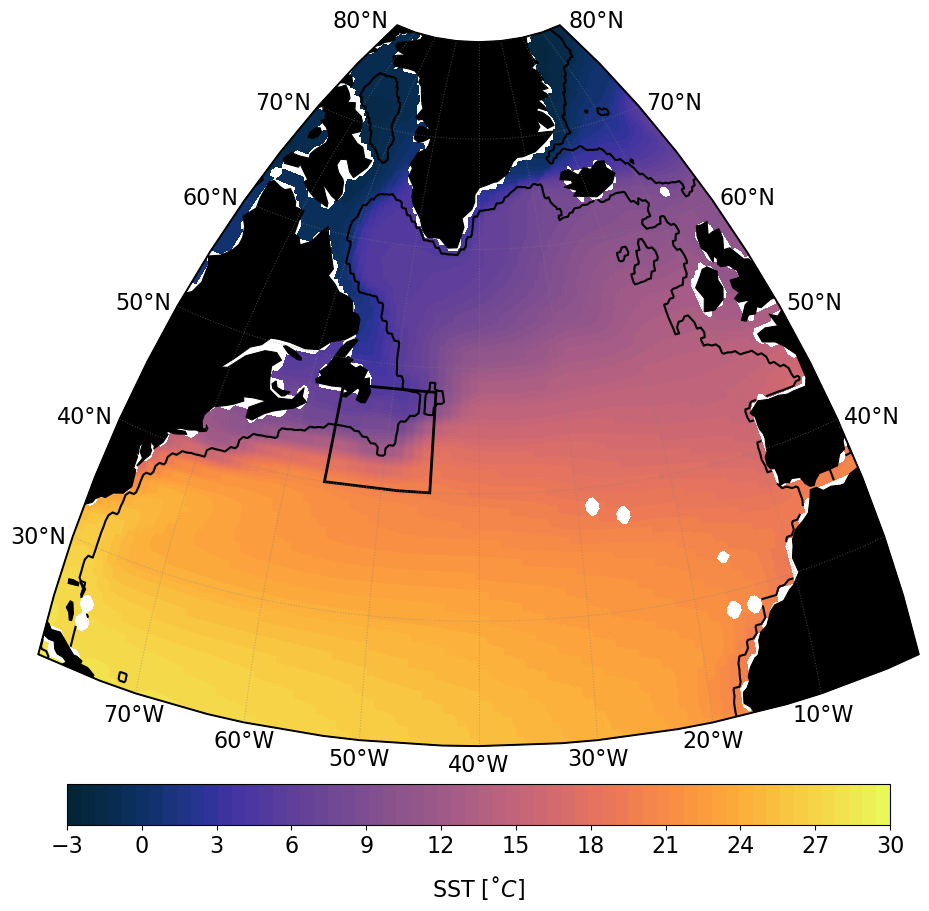

In [19]:
save_name    = 'surface_temperature_test'

plt_var      = ds_mean.THETA[0,:,:]

bbox          = [-80,0,20,80] # Plotting Extent
plot_this_box = [-80,0,0,60]    # Locator box indicating a region
proj          = ccrs.PlateCarree() # Need to add this to most things as "transform=proj"
fig,ax,_      = init_orthomap(1,1,bbox)

# Add Coasts/Continent
ax     = add_coast_grid(ax,bbox,fill_color='k',line_color='k')
levels = np.linspace(-3,30,61)

# Plot contours
colorplot = ax.contourf(lon_mg,lat_mg,plt_var,transform=proj, levels=levels, cmap='cmo.thermal', zorder=0)
cbar = plt.colorbar(colorplot, fraction=0.057, pad=0.01, orientation='horizontal',ticks=np.linspace(-3,30, 12))
cbar.set_label('SST [$˚C$]', size='16', labelpad=11)

plt.contour(ds_bathy.longitude,ds_bathy.latitude,ds_bathy,levels = [1000],colors='k',transform = proj)
#plt.scatter(vels_N.longitude,np.repeat(vels_N.latitude,len(vels_N.longitude)),transform = proj)
cbar.ax.tick_params(labelsize=16)
ax.add_patch(patch.Rectangle((-56,40),11,8,facecolor='None',edgecolor='k',linewidth=2,transform=proj))
#plt.savefig(fig_path  + save_name + '.png', format='png', bbox_inches="tight",dpi=100)

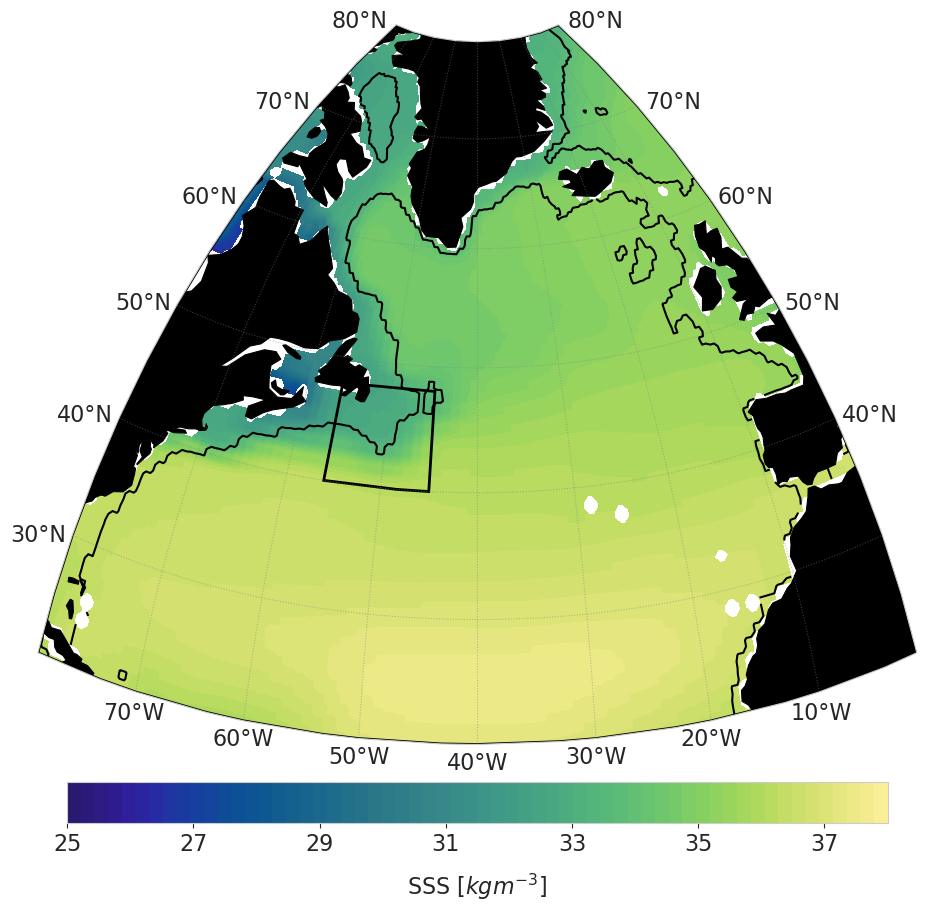

In [48]:
save_name    = 'surface_temperature_test'

plt_var      = ds_mean.SALT[0,:,:]

bbox          = [-80,0,20,80] # Plotting Extent
plot_this_box = [-80,0,0,60]    # Locator box indicating a region
proj          = ccrs.PlateCarree() # Need to add this to most things as "transform=proj"
fig,ax,_      = init_orthomap(1,1,bbox)

# Add Coasts/Continent
ax     = add_coast_grid(ax,bbox,fill_color='k',line_color='k')
levels = np.linspace(25,38,61)

# Plot contours
colorplot = ax.contourf(lon_mg,lat_mg,plt_var,transform=proj, levels=levels, cmap='cmo.haline', zorder=0)
cbar = plt.colorbar(colorplot, fraction=0.057, pad=0.01, orientation='horizontal',ticks=np.linspace(25,37, 7))
cbar.set_label('SSS [$kgm^{-3}$]', size='16', labelpad=11)

plt.contour(ds_bathy.longitude,ds_bathy.latitude,ds_bathy,levels = [1000],colors='k',transform = proj)
#plt.scatter(vels_N.longitude,np.repeat(vels_N.latitude,len(vels_N.longitude)),transform = proj)
cbar.ax.tick_params(labelsize=16)
ax.add_patch(patch.Rectangle((-56,40),11,8,facecolor='None',edgecolor='k',linewidth=2,transform=proj))
#plt.savefig(fig_path  + save_name + '.png', format='png', bbox_inches="tight",dpi=100)

In [23]:
### --- Define TGB BOX --- 
# Min Latitude = 40N; Max Latitude = 47N
# Min Longitude = 55(305)W; Max Longitude = 45(315)W

### -- Extract Velocity Across Northern and Western Boundaries ---
ds_box = ds_mean.sel(latitude = slice(39.75,48.25),longitude = slice(-56.25,-42.75))
vels_N = ds_box.sel(latitude = slice(47.5,48))
vels_W = ds_box.sel(longitude = slice(-56.25,-56))

(-500.0, 0.0)

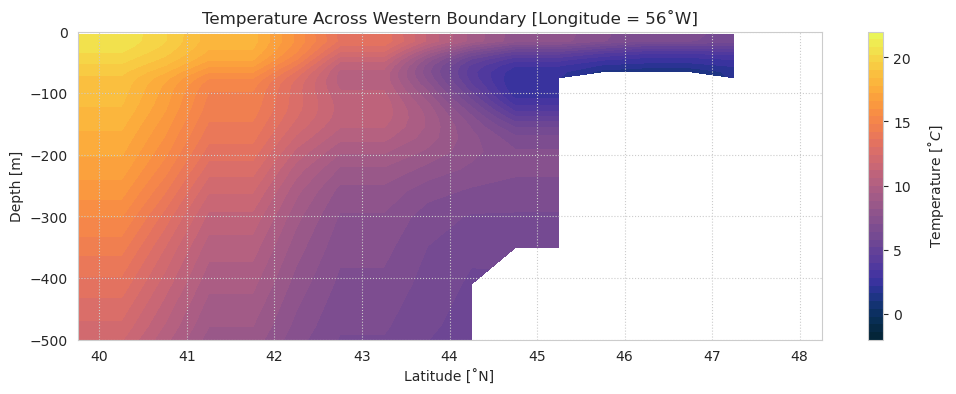

In [57]:
sns.set_style('whitegrid',{"grid.linestyle": ":"})
plt.figure(figsize=[12,4])
levels = np.linspace(-2,22,41)
plt.contourf(vels_W.latitude,vels_W.Z,vels_W.THETA.squeeze(),cmap='cmo.thermal',levels = levels,zorder = 0)
plt.title('Temperature Across Western Boundary [Longitude = 56˚W]')
cbar = plt.colorbar(ticks=np.linspace(0,20, 5))
cbar.set_label('Temperature [$˚C$]',  labelpad=11)
plt.xlabel('Latitude [˚N]')
plt.ylabel('Depth [m]')
plt.ylim([-500, 0])

(-500.0, 0.0)

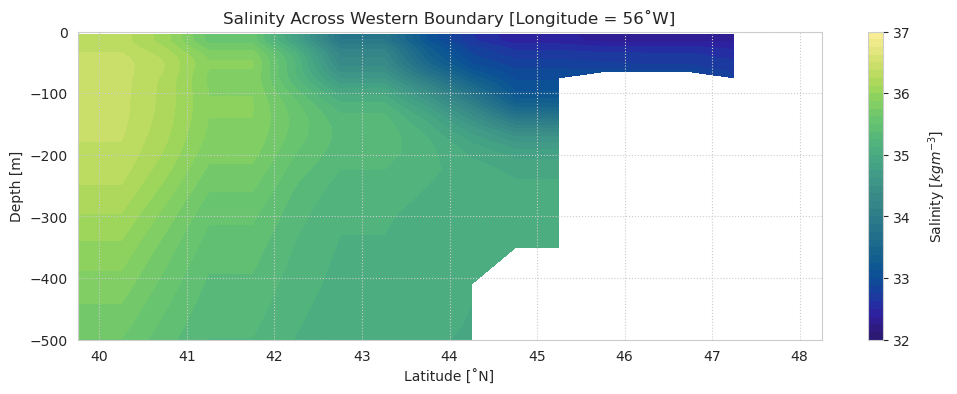

In [52]:
sns.set_style('whitegrid',{"grid.linestyle": ":"})
plt.figure(figsize=[12,4])
levels = np.linspace(32,37,41)
plt.contourf(vels_W.latitude,vels_W.Z,vels_W.SALT.squeeze(),cmap='cmo.haline',levels = levels,zorder = 0)
plt.title('Salinity Across Western Boundary [Longitude = 56˚W]')
cbar = plt.colorbar(ticks=np.linspace(32,37,6))
cbar.set_label('Salinity [$kgm^{-3}$]',  labelpad=11)
plt.xlabel('Latitude [˚N]')
plt.ylabel('Depth [m]')
plt.ylim([-500, 0])

(-500.0, 0.0)

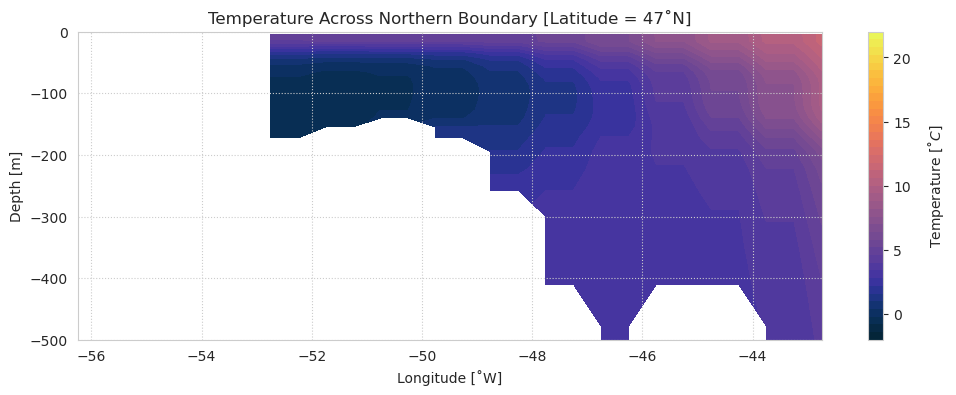

In [56]:
sns.set_style('whitegrid',{"grid.linestyle": ":"})
plt.figure(figsize=[12,4])
levels = np.linspace(-2,22,41)
plt.contourf(vels_N.longitude,vels_N.Z,vels_N.THETA.squeeze(),cmap='cmo.thermal',levels = levels,zorder = 0)
plt.title('Temperature Across Northern Boundary [Latitude = 47˚N]')
cbar = plt.colorbar(ticks=np.linspace(0,20, 5))
cbar.set_label('Temperature [$˚C$]',  labelpad=11)
plt.xlabel('Longitude [˚W]')
plt.ylabel('Depth [m]')
plt.ylim([-500, 0])

(-500.0, 0.0)

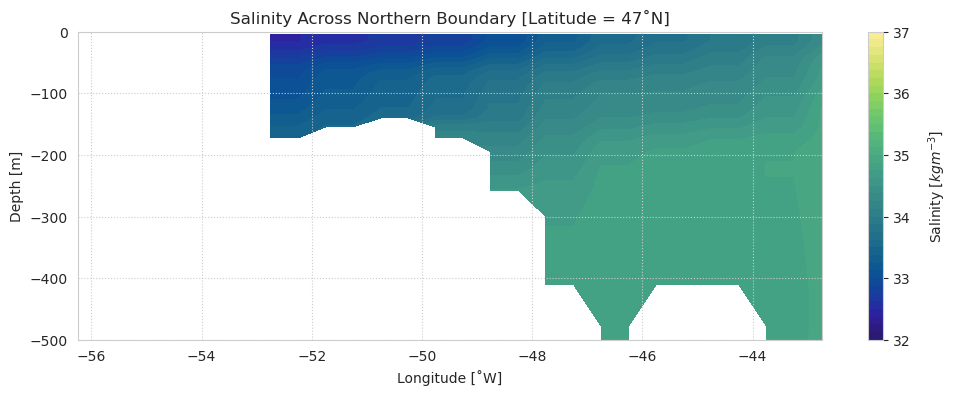

In [55]:
sns.set_style('whitegrid',{"grid.linestyle": ":"})
plt.figure(figsize=[12,4])
levels = np.linspace(32,37,41)
plt.contourf(vels_N.longitude,vels_N.Z,vels_N.SALT.squeeze(),cmap='cmo.haline',levels = levels,zorder = 0)
plt.title('Salinity Across Northern Boundary [Latitude = 47˚N]')
cbar = plt.colorbar(ticks=np.linspace(32,37,6))
cbar.set_label('Salinity [$kgm^{-3}$]',  labelpad=11)
plt.xlabel('Longitude [˚W]')
plt.ylabel('Depth [m]')
plt.ylim([-500, 0])